<a href="https://colab.research.google.com/github/SalvatoreRomano1/net2020/blob/main/Post_Group/Network_statystics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import pandas as pd 
import numpy as np
import os
import networkx as nx

import statsmodels
import statsmodels.api as sm
import scipy.stats as stats
import scipy.sparse as sparse

import matplotlib.pyplot as plt

from operator import itemgetter
import operator
from collections import Counter
import random

In [34]:
pip install powerlaw


In [35]:
pip install python-louvain

In [92]:
import powerlaw
import community as community_louvain

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Networks creation

In [96]:
biad_edges = "edgelist_bipartite_hash_set0.csv"
biad_nodes = "nodelist_bipartite_hash_set0.csv"

proj_nodes = 'nodelist_projection_hash_0.csv'
proj_edges = 'edgelist_projection_hash_0.csv'


In [94]:
# import the csv file 
edgesbiad = pd.read_csv(biad_edges,  sep=',', engine='python')
nodesbiad = pd.read_csv(biad_nodes, sep=',', engine='python')

Gbiad = nx.Graph()
Gbiad = nx.from_pandas_edgelist(edgesbiad, 'source', 'target', ['weight'])	
data = nodesbiad.set_index('Id').to_dict('index').items()
Gbiad.add_nodes_from(data)

In [97]:
nodesproj = pd.read_csv(proj_nodes, sep=',', engine='python')
edgesproj = pd.read_csv(proj_edges,  sep=',', engine='python')

Gproj = nx.Graph()
Gproj = nx.from_pandas_edgelist(edgesproj, 'source', 'target', ['weight'])	
data = nodesproj.set_index('Id').to_dict('index').items()
Gproj.add_nodes_from(data)

# general parameter on projection

In [98]:
def average_2_3_degree(G):
  k = 0
  k_2 = 0
  k_3 = 0
  for i in range(len(G.nodes())):
    k = k+G.degree(i)
    k_2 = k_2 + G.degree(i)*G.degree(i)
    k_3 = k_3 + G.degree(i)*G.degree(i)*G.degree(i)
  k = k/len(G.nodes())
  k_2 = k_2/len(G.nodes())
  k_3 = k_3/len(G.nodes())
  return k,k_2,k_3

def degree_graph(G):
  degree_dict = dict(G.degree(G.nodes()))
  
  min_degree = degree_dict[min(degree_dict, key=degree_dict.get)]
  max_degree = degree_dict[max(degree_dict, key=degree_dict.get)]
  return degree_dict, min_degree, max_degree

def power_law(G):
  degree_sequence = sorted([d for n, d in G.degree()], reverse=True) 
  fit = powerlaw.Fit(degree_sequence) 
  alpha = fit.power_law.alpha
  return alpha



In [99]:
k,k2,k3 = average_2_3_degree(Gproj)
degree_dict, min_degree, max_degree = degree_graph(Gproj)
alpha = power_law(Gproj)
degree_variance = k2 - k*k
density= nx.density(Gproj)
print('Second order average degree: '+str (k2))
print('Third order average degree: '+str (k3))
print('Min degree: '+str(min_degree))
print('Max degree: '+str(max_degree))
print('Power law coefficient: '+str(alpha))
print('Variance: '+str(degree_variance))
print('Density: '+str(density))
print(nx.info(Gproj))

Second order average degree: 48.6875
Third order average degree: 818.4375
Min degree: 0
Max degree: 30
Power law coefficient: 2.4294476797920357
Variance: 28.4375
Density: 0.02830188679245283
Name: 
Type: Graph
Number of nodes: 160
Number of edges: 360
Average degree:   4.5000


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


# diamerter and distance on projection

In [100]:
def diameter_distance_dist(G):
  if nx.is_connected(G):
    diameter = nx.diameter(G)
    ave_dist = nx.average_shortest_path_length(G)
  else:
    big = max(nx.connected_components(G), key=len)
    sub_comp = G.subgraph(big).copy() 
    diameter = nx.diameter(sub_comp)
    ave_dist = nx.average_shortest_path_length(sub_comp)
  return diameter, ave_dist

In [101]:
diameter, average_distance = diameter_distance_dist(Gproj)
print('Network diameter: '+str(diameter))
print('Average path length: '+str(average_distance))

Network diameter: 7
Average path length: 3.1466003316749585


In [102]:
def path_length(G,v):
  return nx.single_source_shortest_path_length(G, v)
def path(G):
  all_path = [l for v in G for l in path_length(G,v).values()]
  count= Counter(all_path)
  label = count.keys()
  path_len = count.values()
  indexes = np.arange(len(label))
  width = 1
  plt.bar(indexes, path_len, align= 'center')# width)
  plt.xticks(indexes,label)
  plt.show()

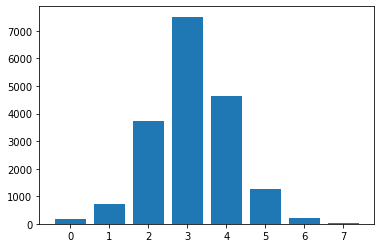

In [104]:
path(Gproj)

# degree distribution on projection

In [105]:
def degree_found(G):
  degree_dict = dict(G.degree(G.nodes()))
  nx.set_node_attributes(G, degree_dict, 'degree')
  return degree_dict

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

def degree_dist(G):
  degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
  count = Counter(degree_sequence)
  dict_count = dict(count)
  k = []
  Pk = []
  PK = []
  #den = G_bi.number_of_nodes()
  den = G.number_of_nodes()
  for key,value in dict_count.items():
    if key != 0:
      k.append(key)
      Pk.append(count[key]/den)
  arr_k = np.array(k)
  arr_Pk = np.array(Pk)
  plt.title('Log-Log PDF function')
  plt.xlabel('k')
  plt.ylabel('Pk')

  plt.loglog(k,Pk, 'o')
  m, c = np.polyfit(np.log(arr_k), np.log(arr_Pk), 1, w=np.sqrt(arr_Pk)) 
  Pk_fit = np.exp(m*np.log(arr_k) + c) 
  plt.loglog(arr_k, Pk_fit, '-')

def degree_dist_CCDF(G):
  degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
  count = Counter(degree_sequence)
  dict_count = dict(count)
  k = []
  Pk = []
  PK = []
  den = G.number_of_nodes()
  for key,value in dict_count.items():
    if key != 0:
      k.append(key)
      Pk.append(count[key]/den)
  PK = np.cumsum(Pk)
  arr_k = np.array(k)
  arr_Pk = np.array(Pk)
  arr_PK = np.array(PK)
  plt.title('Log-Log CCDF function')
  plt.xlabel('k')
  plt.ylabel('CCDF')

  plt.loglog(k,PK, 'o')
  m, c = np.polyfit(np.log(arr_k), np.log(arr_PK), 1, w=np.sqrt(arr_Pk)) 
  PK_fit = np.exp(m*np.log(arr_k) + c) 
  plt.loglog(arr_k, PK_fit, '-')

In [106]:
degree_dict = degree_found(Gproj)

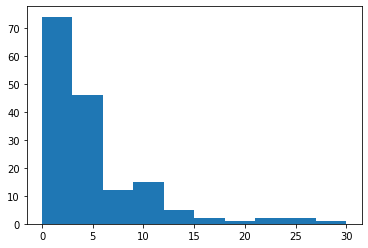

In [107]:
plot_degree_dist(Gproj)

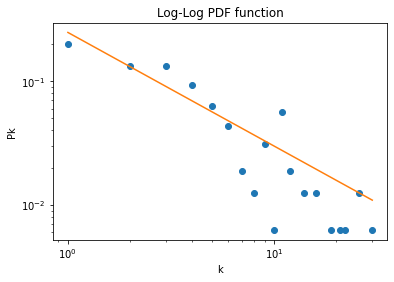

In [108]:
degree_dist(Gproj)

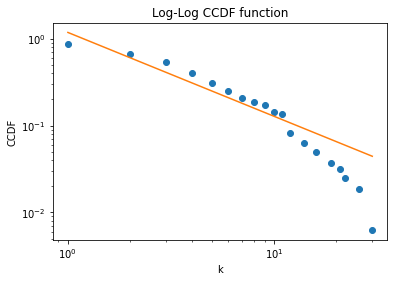

In [109]:
degree_dist_CCDF(Gproj)


# cluster coefficient on both

In [110]:
def disconnected_check(G):
  if not nx.is_connected(G):
    big = max(nx.connected_components(G), key=len)
    g = G.subgraph(big).copy() 
  return g

def proj_net_coef(G):
  degree_dict = degree_found(G)
  nodes = list(degree_dict.keys())
  degree_list = list(degree_dict.values())
  degree_set = set()
  for i in range(len(degree_list)):
    degree_set.add(degree_list[i])
  return degree_set,degree_dict

def cluster_average(G,degree_set,degree_dict):
  cluster_val = []
  for degree in degree_set:
    temp_node = [key for (key,value) in degree_dict.items() if value == degree] 
    temp = nx.average_clustering(G, nodes=temp_node)
    cluster_val.append(temp)
  return cluster_val

def cluster_single(G):
  cluster_val_single = []
  for node in G.nodes():
    temp = nx.clustering(G, nodes=node)
    cluster_val_single.append(temp)
  return cluster_val_single

In [111]:
G_coeff = disconnected_check(Gproj)
degree_set,degree_dict = proj_net_coef(G_coeff)
cluster_val = cluster_average(G_coeff, degree_set,degree_dict)
cluster_single_val = cluster_single(G_coeff)

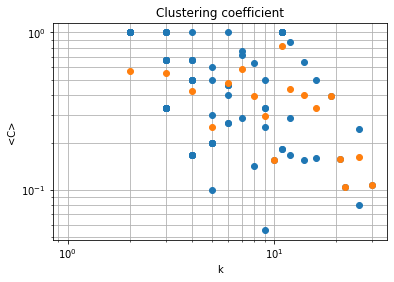

In [112]:
degree_list = list(degree_dict.values())
degree_set_list = list(degree_set)
plt.title('Clustering coefficient')
plt.xlabel('k')
plt.ylabel('<C>')
plt.grid(True, which = 'both')
plt.loglog(degree_list,cluster_single_val, 'o')
plt.loglog(degree_set_list,cluster_val, 'o')

In [113]:
###################################???????????????

avg_pr = nx.average_clustering(G_coeff)
print('Average clustering coefficient: '+ str(avg_pr))

natural_cut = 1*(pow(Gproj.number_of_nodes(),1/(alpha-1)))
print('Natural cutoff: '+ str(natural_cut))

Average clustering coefficient: 0.3795622381920023
Natural cutoff: 34.8287750405625


In [114]:
def bipartite_cluster(G):
  cluster_val_p1 = []
  cluster_val_p2 = []

  if nx.is_connected(G):
    for node in G.nodes():
      temp = nx.square_clustering(G, nodes=node)
      if G.nodes[node]['type'] == 'hashtag':
        cluster_val_p1.append(temp)
      else:
        cluster_val_p2.append(temp)
  else:
    big = max(nx.connected_components(G), key=len)
    sub_comp = G.subgraph(big).copy() 
    for node in sub_comp.nodes():
      temp = nx.square_clustering(sub_comp, nodes=node)
      if sub_comp.nodes[node]['type'] == 'hashtag':
        cluster_val_p1.append(temp)
      else:
        cluster_val_p2.append(temp)

  return cluster_val_p1, cluster_val_p2
    
def multiple_dict(G):
  if nx.is_connected(G):
    degree_dict = degree_found(G)
  else:
    big = max(nx.connected_components(G), key=len)
    sub_comp = G.subgraph(big).copy() 
    degree_dict = degree_found(sub_comp)

  len_hash = 0
  for node in G.nodes():
    if G.nodes[node]['type'] == 'hashtag':
      len_hash = len_hash+1

  dict_v1 = {key:val for key, val in degree_dict.items() if key < len_hash}
  degree_list_v1 = list(dict_v1.values())
  dict_v2 = {key:val for key, val in degree_dict.items() if key >= len_hash}
  degree_list_v2 = list(dict_v2.values())
  return degree_list_v1,degree_list_v2
  #return dict_v1,dict_v2

In [115]:
cluster_val_p1, cluster_val_p2 = bipartite_cluster(Gbiad)
degree_list_v1,degree_list_v2 = multiple_dict(Gbiad)

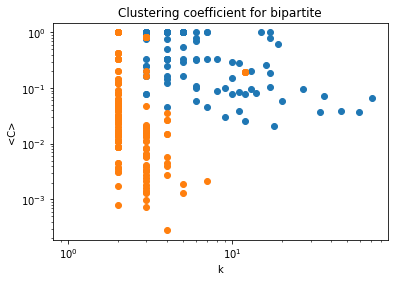

In [116]:
plt.title('Clustering coefficient for bipartite')
plt.xlabel('k')
plt.ylabel('<C>')
#plt.grid(True, which = 'both')
plt.loglog(degree_list_v1, cluster_val_p1, 'o')
plt.loglog(degree_list_v2, cluster_val_p2, 'o')

# Assortativity only on projection

In [122]:
def assortativity(G):
  
  avg_neighbor = nx.average_neighbor_degree(G)   
  avg_neighboor_k = nx.k_nearest_neighbors(G)

  degree = [G.degree(n) for n in G.nodes()]
  avg = list(avg_neighbor.values())

  degree_k = list(avg_neighboor_k.keys())
  avg_k = list(avg_neighboor_k.values())

  plt.loglog(degree, avg,'o')
  plt.loglog(degree_k, avg_k,'o')

  degree_k = np.array(degree_k)
  avg_k = np.array(avg_k)

  '''a = np.log(degree_k)
  b = np.log(avg_k)
  a[np.isneginf(a)] = 0
  b[np.isneginf(b)] = 0

  m, c = np.polyfit(np.log(degree_k),np.log(avg_k), 1, w=np.sqrt(avg_k)) 
  avg_neigh_fit = np.exp(m*degree_k + c)
  plt.loglog(degree_k, avg_neigh_fit, '-')'''

  plt.xlabel("Degree")
  plt.ylabel("Average Neighbour Degree")

  plt.title('Degree Assortativity')
  plt.show()
  

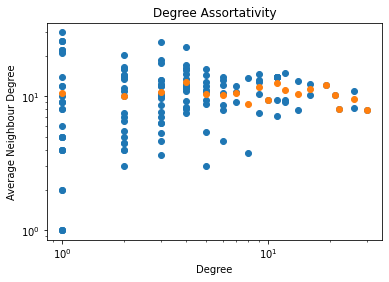

In [123]:
assortativity(Gproj)

In [124]:
ass_deg = nx.degree_assortativity_coefficient(Gproj)
print('Degree asortativity: '+ str(ass_deg))

Degree asortativity: -0.06997461301968143


In [131]:
def emo_assortativity(G):
  if nx.is_connected(G):
    g = G.copy()
  else:
    big = max(nx.connected_components(G), key=len)
    g = G.subgraph(big).copy() 

  emo = []
  for node in g.nodes():
    value = g.nodes[node]['Emo_Neg']
    value = round(value, 2)
    emo.append(value)

  avg_emo = [] 
  for node in g.nodes():
    node_neighbor = g.neighbors(node)
    sum = 0
    count = 0
    for i in node_neighbor:
      sum = sum+g.nodes[i]['Emo_Neg']
      count = count+1
    avg_emo.append(sum/count)

  emo_dict = dict(zip(emo,avg_emo))
  emo_k = list(emo_dict.keys())
  avg_emo_k = list(emo_dict.values())



  plt.loglog(emo, avg_emo,'o')
  plt.loglog(emo_k,avg_emo_k,'o')
  emo_k = np.array(emo_k)
  avg_emo_k = np.array(avg_emo_k)
  '''a = np.log(emo_k)
  b = np.log(avg_emo_k)
  a[np.isneginf(a)] = 0
  b[np.isneginf(b)] = 0
  m, c = np.polyfit(a,b, 1, w=np.sqrt(avg_emo_k)) 
  avg_neigh_fit = np.exp(m*emo_k + c)
  plt.loglog(emo_k, avg_neigh_fit, '-')'''
  plt.xlabel("Emo")
  plt.ylabel("Average Neighbour Emo")

  plt.title('Emo Assortativity')
  plt.show()



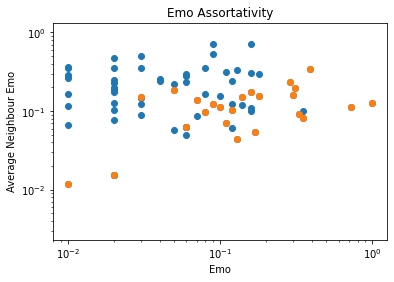

In [132]:
emo_assortativity(Gproj)

In [133]:
ass_emo = nx.attribute_assortativity_coefficient(Gproj, 'Emo_Neg')
print('Degree asortativity: '+ str(ass_emo))

Degree asortativity: 0.08929846365391227


# robustness on both


In [134]:
def emo_dict(nodes):
  label = nodes['Id'].values
  label = label.tolist()
  emo = nodes["Emo_Neg"].to_numpy()
  emo = emo.tolist()
  emo_dictionary = dict(zip(label,emo))
  return emo_dictionary


def robustness(G, dict_characteristic, reverse = True):
    g = G.copy()
    
    m = dict_characteristic
    l = sorted(m.items(), key = operator.itemgetter(1), reverse = reverse)
    
    x = []
    y = []
    largest_component = max(nx.connected_components(g), key = len)
    n = g.number_of_nodes()
    x.append(0)
    y.append(len(largest_component) * 1. / n)
    
    R = 0.0
    
    for i in range(1, n):#len(emo_dictionary)):
      temp = l.pop(0)[0]
      if temp in G:
        g.remove_node(temp)
        largest_component = max(nx.connected_components(g), key = len)
        x.append(i * 1. / n)
        #x.append(i)
        R += len(largest_component) * 1. / n
        y.append(len(largest_component) * 1. / n)
     
    return x, y, 0.5 - R / n

def robustness_failure(G, dict_characteristic, reverse = True):
  g = G.copy()

  x = []
  y = []
  largest_component = max(nx.connected_components(g), key = len)
  n = g.number_of_nodes()
  x.append(0)
  y.append(len(largest_component) * 1. / n)
  m = dict_characteristic   
  R = 0.0

  for i in range(1, n):
    keys =  list(m.keys())
    random.shuffle(keys)
    shuffled_m = dict()
    for key in keys:
      shuffled_m.update({key:m[key]})
    m = shuffled_m

    temp = list(m.keys())[0]
    del m[temp]

    if temp in g:
      g.remove_node(temp)
      largest_component = max(nx.connected_components(g), key = len)
      x.append(i * 1. / n)  
      R += len(largest_component) * 1. / n
      y.append(len(largest_component) * 1. / n)
  return x, y, 0.5 - R / n


In [135]:
emo_dictionary_bi = emo_dict(nodesbiad)
emo_dictionary_pr = emo_dict(nodesproj)

In [136]:
x_pr_emo, y_pr_emo, R_pr_emo = robustness(Gproj,emo_dictionary_pr)
x_fail_pr_emo, y_fail_pr_emo, R_fail_pr_emo = robustness_failure(Gproj,emo_dictionary_pr)

print('Attack robustness: ' +str(R_pr_emo))
print('Failure robustness: ' +str(R_fail_pr_emo))

Attack robustness: 0.29683593749999954
Failure robustness: 0.14710937499999976


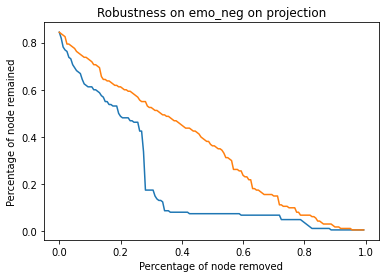

In [137]:
plt.title('Robustness on emo_neg on projection')
plt.xlabel('Percentage of node removed')
plt.ylabel('Percentage of node remained')
plt.plot(x_pr_emo,y_pr_emo)
plt.plot(x_fail_pr_emo,y_fail_pr_emo)

In [138]:
####????
def average_1_2_emo(G):
  k = 0
  k_2 = 0
  for i in range(len(G.nodes())):
    k = k+G.nodes[i]['Emo_Neg']
    k_2 = k_2 + G.nodes[i]['Emo_Neg']*G.nodes[i]['Emo_Neg']
  k = k/len(G.nodes())
  k_2 = k_2/len(G.nodes())

  return k,k_2

In [139]:
emo1, emo2 = average_1_2_emo(Gproj)
f_c_emo = 1-1/((emo2/emo1)-1)
print('Breaking point fc: '+str(f_c_emo))

Breaking point fc: 2.428889909924263


In [140]:
degree_dict_pr = degree_found(Gproj)
x_pr_deg, y_pr_deg, R_pr_deg = robustness(Gproj,degree_dict_pr)
x_fail_pr_deg, y_fail_pr_deg, R_fail_pr_deg = robustness_failure(Gproj,degree_dict_pr)

print('Attack robustness: ' +str(R_pr_deg))
print('Failure robustness: ' +str(R_fail_pr_deg))

Attack robustness: 0.3896484374999998
Failure robustness: 0.1679296874999996


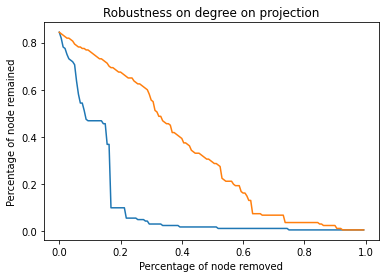

In [141]:
plt.title('Robustness on degree on projection')
plt.xlabel('Percentage of node removed')
plt.ylabel('Percentage of node remained')
plt.plot(x_pr_deg, y_pr_deg)
plt.plot(x_fail_pr_deg, y_fail_pr_deg)

In [142]:
x_bi_emo, y_bi_emo, R_bi_emo = robustness(Gbiad,emo_dictionary_bi)
x_fail_bi_emo, y_fail_bi_emo, R_fail_bi_emo = robustness_failure(Gbiad,emo_dictionary_bi)

print('Attack robustness: ' +str(R_bi_emo))
print('Failure robustness: ' +str(R_fail_bi_emo))

Attack robustness: 0.3558375250471152
Failure robustness: 0.21548886005254803


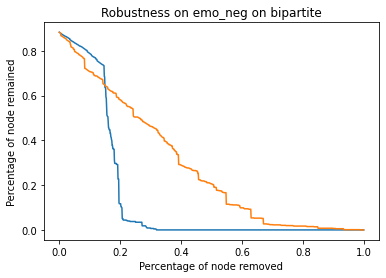

In [143]:
plt.title('Robustness on emo_neg on bipartite')
plt.xlabel('Percentage of node removed')
plt.ylabel('Percentage of node remained')
plt.plot(x_bi_emo, y_bi_emo)
plt.plot(x_fail_bi_emo, y_fail_bi_emo)

In [144]:
degree_dict_bi = degree_found(Gbiad)
x_bi_deg, y_bi_deg, R_bi_deg = robustness(Gbiad,degree_dict_bi)
x_fail_bi_deg, y_fail_bi_deg, R_fail_bi_deg = robustness_failure(Gbiad,degree_dict_bi)

print('Attack robustness: ' +str(R_bi_deg))
print('Failure robustness: ' +str(R_fail_bi_deg))

Attack robustness: 0.4790807881186115
Failure robustness: 0.22078027777650877


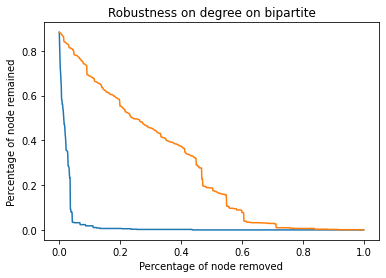

In [145]:
plt.title('Robustness on degree on bipartite')
plt.xlabel('Percentage of node removed')
plt.ylabel('Percentage of node remained')
plt.plot(x_bi_deg, y_bi_deg)
plt.plot(x_fail_bi_deg, y_fail_bi_deg)

In [146]:
f_c_deg = 1-1/((k2/k)-1)
print('Breaking point fc: '+str(f_c_deg))

Breaking point fc: 0.8981612446958982


# page rank only on projection

In [147]:
def page_hist(G):
  if nx.is_connected(G):
    pagerank = nx.pagerank(G)
    hits = nx.hits(G, max_iter = 300)
  else:
    big = max(nx.connected_components(G), key=len)
    sub_comp = G.subgraph(big).copy() 
    pagerank = nx.pagerank(sub_comp)
    hits = nx.hits(sub_comp, max_iter = 300)

  value_pagerank = list(pagerank.values())
  autority = hits[1]
  value_autority = list(autority.values())

  neg_pagerank = []
  for i in range(len(value_pagerank)):
    neg_pagerank.append(-1*value_pagerank[i])

  return value_pagerank, neg_pagerank, value_autority

def top_pagerank(G,num):
  if nx.is_connected(G):
    pagerank = nx.pagerank(G)
  else:
    big = max(nx.connected_components(G), key=len)
    sub_comp = G.subgraph(big).copy() 
    pagerank = nx.pagerank(sub_comp)

  sorted_pagerank = sorted(pagerank.items(), key=itemgetter(1), reverse=True)
  top_pagerank = sorted_pagerank[:num]
  return top_pagerank


In [148]:
pagerank, neg_pagerank, hits = page_hist(Gproj)

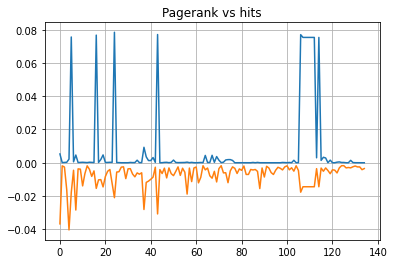

In [149]:
plt.title('Pagerank vs hits')
plt.grid(True)
plt.plot(hits)
plt.plot(neg_pagerank)

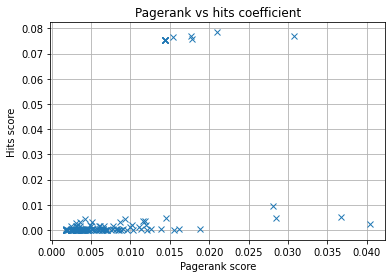

In [150]:
plt.title('Pagerank vs hits coefficient')
plt.grid(True)
plt.xlabel('Pagerank score')
plt.ylabel('Hits score')
plt.plot(pagerank,hits, 'x')

In [158]:
'''page_r = nx.pagerank(Gproj)
sorted_page = sorted(page_r.items(), key=itemgetter(1), reverse=True)
top_page_score = sorted_page[:20]'''

# Community on projection

In [161]:
def louv_mod(G,resolution):
  if nx.is_connected(G):
    modularity_dict = community_louvain.best_partition(G,resolution=2.0)
    mod = community_louvain.modularity(modularity_dict,G)
  else:
    big = max(nx.connected_components(G), key=len)
    g = G.subgraph(big).copy() 
    modularity_dict = community_louvain.best_partition(g,resolution=2.0)
    mod = community_louvain.modularity(modularity_dict,g)
  
  return modularity_dict, mod

In [162]:
res = 2
mod_dict, mod_val = louv_mod(Gproj,res)

In [163]:
nx.set_node_attributes(Gproj, mod_dict, 'modularity')
print('Modularity value: '+str(mod_val))

Modularity value: 0.554852558111465
